# GPT—SOVITS


## 1. 模型项目介绍和环境准备

### 1.1 项目说明
本项目基于开源项目 https://github.com/RVC-Boss/GPT-SoVITS 改动而成，该项目可以做到强大的少样本语音转换与语音合成，并提供了webUI支持。

本项目在原始项目中添加了cli训练-推理脚本，并且添加该notebook文档，通过该文档能够实现整个数据处理、微调训练、推理语音合成的工作流。

### 1.2 环境准备
该项目所需要的所有第三方程序如(ffmpeg)和依赖已经在容器内包含，容器名称：gpt-sovits:jupyterlab-torch2.1-dtk23.04-py38，用户无需再进行依赖安装。

如不是使用该容器，则需要自行搭建相关环境，并且执行

In [ ]:
### 非 gpt-sovits:jupyterlab-torch2.1-dtk23.04-py38 容器环境需要执行依赖安装
pip install -r requirements.txt

## 2. 数据集处理

### 2.1 人声音频提取和增强

使用 UVR5 进行人声/伴奏分离和混响移除，该部分建议使用 https://github.com/Anjok07/ultimatevocalremovergui 项目在本地进行
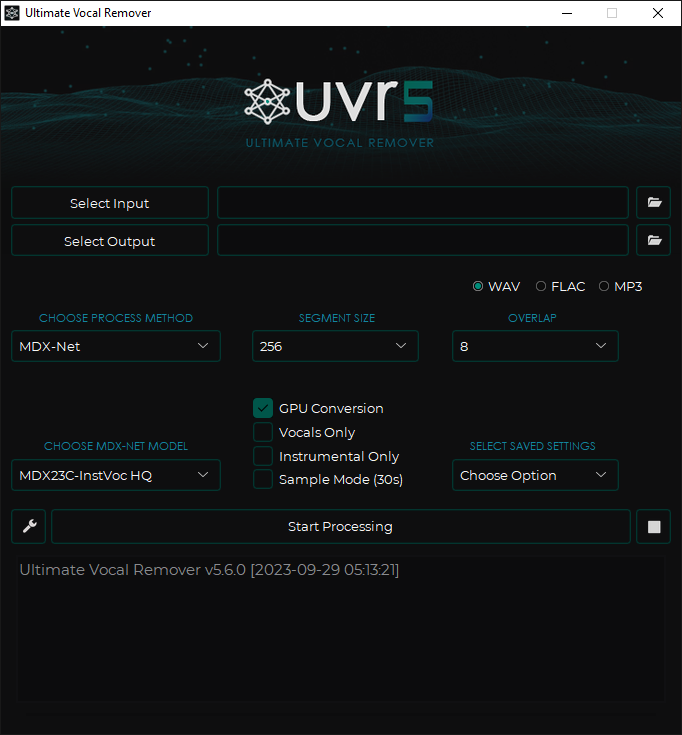

### 2.2 人声切分

使用 `tools/slice_audio.py` 切分输入音频，其输入参数定义为

    --input_path # 输入音频文件或目录
    --output_root # 输出音频目录
    --threshold  # 音量小于这个值视作静音的备选切割点
    --min_length  # 每段最小多长，如果第一段太短一直和后面段连起来直到超过这个值
    --min_interval  # 最短切割间隔
    --hop_size  # 怎么算音量曲线，越小精度越大计算量越高（不是精度越大效果越好）
    --max_sil_kept  # 切完后静音最多留多长
    --alpha
    --i_part  
    --all_part 
需要确保输入目录下有音频文件，并且输出路径存在

In [ ]:
!python tools/slice_audio.py   data/input_vocals/ data/sliced/ -34 4000 300 10 500 0.9 0.25 0 1

### 2.3 使用asr进行文本标注

使用 `tools/asr/funasr_asr.py` 进行数据标注

#### 2.3.1 仅中文asr

下载 Damo ASR 、Damo VAD 和 Damo Punc 三个模型

In [1]:
# Damo ASR Model
!git-lfs clone https://www.modelscope.cn/iic/speech_paraformer-large_asr_nat-zh-cn-16k-common-vocab8404-pytorch.git

Cloning into 'speech_paraformer-large_asr_nat-zh-cn-16k-common-vocab8404-pytorch'...
remote: Enumerating objects: 465, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 465 (delta 40), reused 60 (delta 32), pack-reused 395
Receiving objects: 100% (465/465), 1.12 GiB | 57.85 MiB/s, done.
Resolving deltas: 100% (268/268), done.


In [2]:
# Damo VAD Model
!git lfs clone  https://www.modelscope.cn/iic/speech_fsmn_vad_zh-cn-16k-common-pytorch.git

Cloning into 'speech_fsmn_vad_zh-cn-16k-common-pytorch'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 183 (delta 18), reused 23 (delta 10), pack-reused 145
Receiving objects: 100% (183/183), 4.66 MiB | 0 bytes/s, done.
Resolving deltas: 100% (91/91), done.


In [3]:
# Damo Punc Model 
!git clone https://www.modelscope.cn/iic/punc_ct-transformer_zh-cn-common-vocab272727-pytorch.git

Cloning into 'punc_ct-transformer_zh-cn-common-vocab272727-pytorch'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 170 (delta 23), reused 27 (delta 12), pack-reused 123
Receiving objects: 100% (170/170), 257.56 MiB | 57.98 MiB/s, done.
Resolving deltas: 100% (86/86), done.


然后将模型文件移动到 `tools/asr/model`目录下

In [4]:
!mv punc_ct-transformer_zh-cn-common-vocab272727-pytorch tools/asr/models/
!mv speech_fsmn_vad_zh-cn-16k-common-pytorch tools/asr/models/
!mv speech_paraformer-large_asr_nat-zh-cn-16k-common-vocab8404-pytorch tools/asr/models/

**执行中文asr标注**

使用 `tools/asr/funasr_asr.py` 进行数据标注，其参数为 -i <input_dir> -o <output_dir>

input_dir 为之前切分好的音频目录
output_dir 为asr标注文件所在目录

In [ ]:
!python tools/asr/funasr_asr.py -i data/leijun -o data/leijun_asr

In [7]:
!cat data/leijun_asr/leijun.list

data/leijun/leijun_Vocals.wav_0000041600_0000226240.wav|leijun|ZH|一九八七年，我呢考上了武汉大学的计算机系。
data/leijun/leijun_Vocals.wav_0000236800_0000376640.wav|leijun|ZH|在武汉大学的图书馆里看了一本书。
data/leijun/leijun_Vocals.wav_0000387200_0000522880.wav|leijun|ZH|硅谷之火建立了我一生的梦想。
data/leijun/leijun_Vocals.wav_0000543680_0000664640.wav|leijun|ZH|看完书以后，热血沸腾。
data/leijun/leijun_Vocals.wav_0000677440_0000804160.wav|leijun|ZH|激动的睡不着觉，我还记得。
data/leijun/leijun_Vocals.wav_0000809280_0000990720.wav|leijun|ZH|那天晚上星光很亮，我就在武大的操场上。
data/leijun/leijun_Vocals.wav_0000992960_0001130240.wav|leijun|ZH|就是屏幕上这个操场走了一圈又一圈。
data/leijun/leijun_Vocals.wav_0001130240_0001283520.wav|leijun|ZH|走了整整一个晚上，我心里有团火。
data/leijun/leijun_Vocals.wav_0001295680_0001449920.wav|leijun|ZH|我也想办一个伟大的公司，梦想之火。
data/leijun/leijun_Vocals.wav_0001449920_0001555520.wav|leijun|ZH|在我心里彻底点燃了。
data/leijun/leijun_Vocals.wav_0001596800_0001804480.wav|leijun|ZH|但是一个大一的新生，一个从县城里出来的年轻人。
data/leijun/leijun_Vocals.wav_0001819840_0002005120.wav|leijun|ZH|什么也不会，什么也没有，就想创办一家伟大

## 2.4 数据集预处理

使用处理脚本 `dataset.py` 对数据集进行预处理

In [27]:
!python dataset.py

"/opt/conda/bin/python" GPT_SoVITS/prepare_datasets/1-get-text.py
进度：1a-ing {'__type__': 'update', 'visible': False} {'__type__': 'update', 'visible': True}
/usr/local/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.610 seconds.
Prefix dict has been built succesfully.
进度：1a-done {'__type__': 'update', 'visible': False} {'__type__': 'update', 'visible': True}
"/opt/conda/bin/python" GPT_SoVITS/prepare_datasets/2-get-hubert-wav32k.py
进度：1a-done, 1b-ing {'__type__': 'update', 'visible': False} {'__type__': 'update', 'visible': True}
/usr/local/li

## 3. 微调训练

### 3.1 预训练模型获取

从 [GPT-SoVITS Models](https://www.icloud.com.cn/iclouddrive/056y_Xog_HXpALuVUjscIwTtg#GPT-SoVITS_Models) 下载预训练模型，并将它们放置在 `GPT_SoVITS\pretrained_models` 中。

In [21]:
!wget 'https://cvws.icloud-content.com.cn/B/AaE_vVmIx3XW4wn54s2phtftGwbMAZbr5IO5sVAB_LAbwMor9aEsllVA/GPT-SoVITS%20Models.zip?o=Aku3mU5tnJ3sR0xDg_NwD3j1UzluqZPUHCl-w87Jf_On&v=1&x=3&a=CAogTs_Z7lB2kht-fIwFG1SpKoT1eYi-WVl2HXH-AjlfH1ISbxCMxPuz7jEYjKHXte4xIgEAUgTtGwbMWgQsllVAaifeyPH3h4067fjPRlB-nnymEbl5CkooX-NsMbKZtOZ6HXM1v_eZG4lyJ9Cnu1jr9d5QVIMs1BlnMu3KHdZBR9sKQEIS4dWbeA2Y4ZRU3CU2Ew&e=1713267658&fl=&r=0f219a8b-6b5a-45e1-af67-921aca4634ad-1&k=N9JhTTm-gpIO_al6zJ5IIw&ckc=com.apple.clouddocs&ckz=com.apple.CloudDocs&p=211&s=TuHGHxVF2yJ9Ej-6TBM8Kn8EUfk&+=d6bd8265-ec76-4eab-886b-e1e41a127f2b' -O GPT-SoVITS_Models.zip 

--2024-04-16 18:55:15--  https://cvws.icloud-content.com.cn/B/AaE_vVmIx3XW4wn54s2phtftGwbMAZbr5IO5sVAB_LAbwMor9aEsllVA/GPT-SoVITS%20Models.zip?o=Aku3mU5tnJ3sR0xDg_NwD3j1UzluqZPUHCl-w87Jf_On&v=1&x=3&a=CAogTs_Z7lB2kht-fIwFG1SpKoT1eYi-WVl2HXH-AjlfH1ISbxCMxPuz7jEYjKHXte4xIgEAUgTtGwbMWgQsllVAaifeyPH3h4067fjPRlB-nnymEbl5CkooX-NsMbKZtOZ6HXM1v_eZG4lyJ9Cnu1jr9d5QVIMs1BlnMu3KHdZBR9sKQEIS4dWbeA2Y4ZRU3CU2Ew&e=1713267658&fl=&r=0f219a8b-6b5a-45e1-af67-921aca4634ad-1&k=N9JhTTm-gpIO_al6zJ5IIw&ckc=com.apple.clouddocs&ckz=com.apple.CloudDocs&p=211&s=TuHGHxVF2yJ9Ej-6TBM8Kn8EUfk&+=d6bd8265-ec76-4eab-886b-e1e41a127f2b
Connecting to 10.15.100.43:3120... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1100181255 (1.0G) [application/zip]
Saving to: ‘GPT-SoVITS_Models.zip’

100%[====================================>] 1,100,181,255 28.4MB/s   in 45s    

2024-04-16 18:56:01 (23.4 MB/s) - ‘GPT-SoVITS_Models.zip’ saved [1100181255/1100181255]



In [22]:
!unzip GPT-SoVITS_Models.zip  -d ./GPT_SoVITS/

Archive:  GPT-SoVITS_Models.zip
   creating: ./GPT_SoVITS/pretrained_models/
 extracting: ./GPT_SoVITS/pretrained_models/.gitignore  
   creating: ./GPT_SoVITS/pretrained_models/chinese-hubert-base/
  inflating: ./GPT_SoVITS/pretrained_models/chinese-hubert-base/config.json  
  inflating: ./GPT_SoVITS/pretrained_models/chinese-hubert-base/preprocessor_config.json  
  inflating: ./GPT_SoVITS/pretrained_models/chinese-hubert-base/pytorch_model.bin  
   creating: ./GPT_SoVITS/pretrained_models/chinese-roberta-wwm-ext-large/
  inflating: ./GPT_SoVITS/pretrained_models/chinese-roberta-wwm-ext-large/config.json  
  inflating: ./GPT_SoVITS/pretrained_models/chinese-roberta-wwm-ext-large/pytorch_model.bin  
  inflating: ./GPT_SoVITS/pretrained_models/chinese-roberta-wwm-ext-large/tokenizer.json  
  inflating: ./GPT_SoVITS/pretrained_models/s1bert25hz-2kh-longer-epoch=68e-step=50232.ckpt  
  inflating: ./GPT_SoVITS/pretrained_models/s2D488k.pth  
  inflating: ./GPT_SoVITS/pretrained_models/s2G4

## 3.2 SoVits模型微调
提供了sovits微调脚本 `train_sovits.py`

In [28]:
!python train_sovits.py

SoVITS训练开始："python" GPT_SoVITS/s2_train.py --config "experiments/tmp_s2.json" {'__type__': 'update', 'visible': False} {'__type__': 'update', 'visible': True}
"python" GPT_SoVITS/s2_train.py --config "experiments/tmp_s2.json"
INFO:train-01:{'train': {'log_interval': 100, 'eval_interval': 500, 'seed': 1234, 'epochs': 10, 'learning_rate': 0.0001, 'betas': [0.8, 0.99], 'eps': 1e-09, 'batch_size': 6, 'fp16_run': False, 'lr_decay': 0.999875, 'segment_size': 20480, 'init_lr_ratio': 1, 'warmup_epochs': 0, 'c_mel': 45, 'c_kl': 1.0, 'text_low_lr_rate': 4, 'pretrained_s2G': 'GPT_SoVITS/pretrained_models/s2G488k.pth', 'pretrained_s2D': 'GPT_SoVITS/pretrained_models/s2D488k.pth', 'if_save_latest': True, 'if_save_every_weights': True, 'save_every_epoch': 2, 'gpu_numbers': '0'}, 'data': {'max_wav_value': 32768.0, 'sampling_rate': 32000, 'filter_length': 2048, 'hop_length': 640, 'win_length': 2048, 'n_mel_channels': 128, 'mel_fmin': 0.0, 'mel_fmax': None, 'add_blank': True, 'n_speakers': 300, 'cleane

### 3.3 GPT模型微调
提供了gpt微调脚本 `train_gpt.py`

In [33]:
!python train_gpt.py

GPT训练开始："/opt/conda/bin/python" GPT_SoVITS/s1_train.py --config_file "/public/home/jsyadmin/AI_model/GPT_SoVits/GPT-SoVITS/TEMP/tmp_s1.yaml"  {'__type__': 'update', 'visible': False} {'__type__': 'update', 'visible': True}
"/opt/conda/bin/python" GPT_SoVITS/s1_train.py --config_file "/public/home/jsyadmin/AI_model/GPT_SoVits/GPT-SoVITS/TEMP/tmp_s1.yaml" 
Seed set to 1234
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
<All keys matched successfully>
ckpt_path: None
[rank: 0] Seed set to 1234
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
I0416 19:50:30.077071 22316 ProcessGroupNCCL.cpp:686] [Rank 0] ProcessGroupNCCL initialization options:NCCL_ASYNC_ERROR_HANDLING: 1, NCCL_DESYNC_DEBUG: 0, NCCL_ENABLE_TIMING: 0, NCCL_BLOCKING_WAIT: 0, TIMEOUT(ms): 1800000, USE_HIGH_PRIORITY_STREAM: 0, TORCH_DISTRIBUTED_DEBUG: OFF, NCCL_DEBUG: OFF, ID=250191216
---------------------------------

## 4. 开始推理

提供了基于微调的推理脚本 `infer.py`

使用方式

-input_text            在这里输入要生成的文本

--output_path           输出音频文件路径
                
--ref_wav_path          提示音频的路径
                
--prompt_text           提示文本的路径 
            
--prompt_language       提示音频的语言 
                
--text_language         输入文本的语言 

--gpt_path              gpt模型文件名

--sovits_path           sovits模型文件名 

"中文": "all_zh",     # 全部按中文识别

"英文": "en",         # 全部按英文识别#######不变

"日文": "all_ja",     # 全部按日文识别

"中英混合": "zh",     # 按中英混合识别####不变

"日英混合": "ja",     # 按日英混合识别####不变

"多语种混合": "auto", # 多语种启动切分识别语种


In [41]:
!python infer.py \
        --input_text="大家好，我是雷军！" \
        --text_language="all_zh" \
        --output_path="data/output_leijun.wav"


TTS inference process is opened
"/opt/conda/bin/python" GPT_SoVITS/inference_cli.py
loading tokenizer...
loading bert...
/usr/local/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
loading ssl_model...
Some weights of the model checkpoint at GPT_SoVITS/pretrained_models/chinese-hubert-base were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected

## 5. 相关引用
-https://github.com/RVC-Boss/GPT-SoVITS/tree/main
